In [2]:
import os, csv
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

file = 'Sonoma_County_Animal_Shelter_Intake_and_Outcome.csv'     
        
dane_schronisko = pd.read_csv(file, delimiter=",")

dane = dane_schronisko

dane = dane[dane['Type'] == 'DOG']
dane = dane[dane['Outcome Type'] == 'ADOPTION']
dane = dane[pd.notna(dane['Date Of Birth'])]
dane = dane[pd.notna(dane['Intake Date'])]
dane = dane[pd.notna(dane['Outcome Date'])]

dane = dane[['Date Of Birth', 'Intake Date', 'Outcome Date', 'Days in Shelter']]

dane['Date Of Birth']= pd.to_datetime(dane['Date Of Birth'], format='%m/%d/%Y')
dane['Intake Date']= pd.to_datetime(dane['Intake Date'], format='%m/%d/%Y')
dane['Outcome Date']= pd.to_datetime(dane['Outcome Date'], format='%m/%d/%Y')

dane=dane[dane['Outcome Date'].dt.year == 2020]

dane.insert(1, 'Age On Intake', (dane['Intake Date']-dane['Date Of Birth']) / np.timedelta64(1, 'M'))
dane['Age On Intake']=dane['Age On Intake'].astype(int)

dane = dane[dane['Days in Shelter'] >=0]
dane = dane[dane['Age On Intake'] >=0]
dane = dane[['Days in Shelter', 'Age On Intake']]

dane = dane.groupby('Age On Intake', as_index=False).mean()

X = dane['Age On Intake'].values
Y = dane['Days in Shelter'].values

dane.sample(10)

,Age On Intake,Days in Shelter
2,3,27.000000
9,11,18.800000
11,17,21.800000
10,16,29.000000
27,59,12.666667
20,36,14.666667
16,29,17.000000
8,10,14.000000
33,120,29.000000
23,44,8.000000


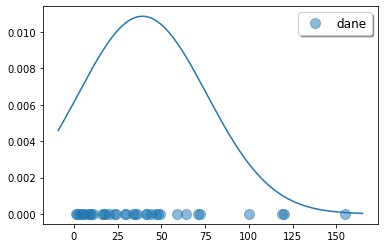

In [3]:
def rozklad_norm(parametry, x):
    mu, sigma = parametry
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

mu, sigma = X.mean(), X.std()
os_x = np.linspace(X.min()-10, X.max()+10, num=300)
os_y = rozklad_norm([mu, sigma], os_x)

plt.plot(os_x, os_y)
plt.plot(X, np.zeros_like(X), 'o', 
             markersize=10, alpha=0.5, markerfacecolor='tab:blue', markeredgecolor='tab:blue', 
             label='dane')
plt.legend(fontsize=12, shadow=True)

In [4]:
from scipy import stats

print(X.size)
print(f'Test Shapiro, p-wartość = {stats.shapiro(X)[1]}')
print(f'Test D’Agostino i Pearsona, p-wartość = {stats.normaltest(X)[1]}\n')

35
Test Shapiro, p-wartość = 0.00020023893739562482
Test D’Agostino i Pearsona, p-wartość = 0.0005818525423661363



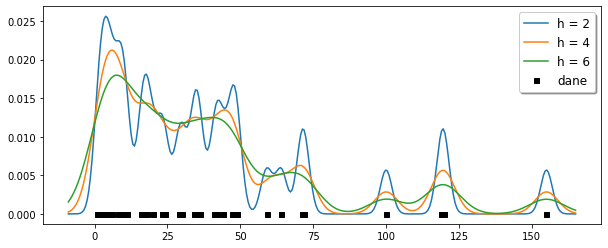

In [5]:
def K(x):
  return np.exp(-x**2/2)/np.sqrt(2*np.pi)

H = [2, 4, 6]
N = X.size

plt.figure(figsize=(10,4))
for h in H:
  suma = 0
  for nr, pomiar in enumerate(X):
    suma += K((os_x-pomiar)/h)
    #plt.annotate(r'$x_{}$'.format(nr+1), xy=[X[nr],0.05], horizontalalignment='center', fontsize=8)
  os_y = suma/(h*N)
  plt.plot(os_x, os_y, label=f'h = {h}')
  

plt.plot(X, np.zeros_like(X) , 's', markersize=5, color='black', label='dane')
plt.legend(fontsize=12, shadow=True)
plt.show()

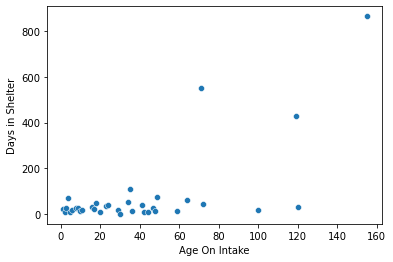

In [6]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='Age On Intake', y='Days in Shelter', data=dane, sizes=(20, 200), legend='brief')
plt.show()

3.115573575537075   -42.51600570300346


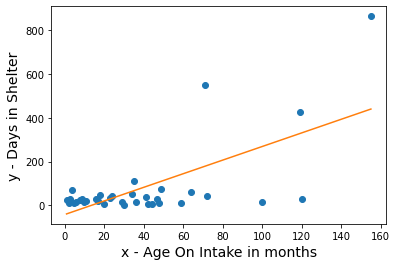

Błąd średniokwadratowy modelu liniowego: 1.71e+04



In [27]:
from numpy import sum, average

X = dane['Age On Intake'].values
Y = dane['Days in Shelter'].values

def model(parametry, x):
  a, b = parametry
  return a*x + b

a_est = (sum(X*Y) - average(Y)*sum(X))/(sum(X*X) - average(X)*sum(X))
b_est = average(Y) - a_est*average(X)

print(a_est, " ", b_est)

X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model(parametry=[a_est, b_est], x=X_test)    

plt.scatter(X,Y)
plt.plot(X_test, Y_pred, color='tab:orange')
plt.xlabel('x - Age On Intake in months', fontsize=14)
plt.ylabel('y - Days in Shelter', fontsize=14)
plt.show()

Y_pred_values = a_est*X+b_est
MSE_lin = mean_squared_error(Y, Y_pred_values)
print(f'Błąd średniokwadratowy modelu liniowego: {MSE_lin:0.3}\n')

[[  3.11557358]
 [-42.5160057 ]]


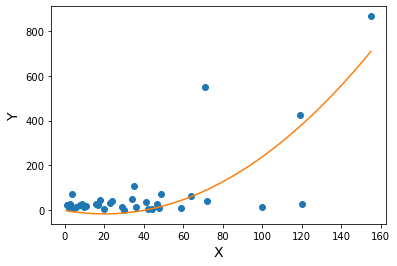

Błąd średniokwadratowy modelu GLM: 1.33e+04



In [59]:
from numpy.linalg import inv

def model(teta, x):
    return teta[0]*teta[1]*(-0.0003*x**2+0.012*x)

X_copy = X.reshape(1,X.size)
Y_copy = Y.reshape(1,Y.size)
row = np.ones(X.size)
X2 = np.append(X_copy,[row],axis= 0)
teta = inv(X2@(X2.T))@X2@(Y_copy.T)
print(teta)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model(teta=teta, x=X_test)

plt.scatter(X_copy,Y_copy)
plt.plot(X_test, Y_pred, color='tab:orange')
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.show()

Y_pred_values = model(teta=teta, x=X)
MSE_GLM = mean_squared_error(Y, Y_pred_values)
print(f'Błąd średniokwadratowy modelu GLM: {MSE_GLM:0.3}\n')

Parametry modelu GLM: [ 0.     -2.6501  0.0425], 59.48218
Błąd średniokwadratowy modelu GLM: 1.35e+03



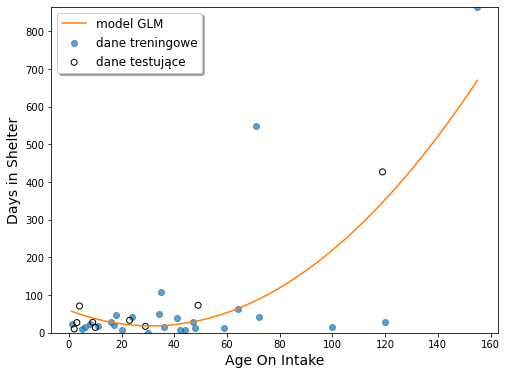

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
model_GLM = LinearRegression()
gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
model_GLM.fit(gen_features.fit_transform(X_train.reshape(-1,1)), 
              Y_train)
print(f'Parametry modelu GLM: {np.round(model_GLM.coef_,4)}, {np.round(model_GLM.intercept_,5)}')
MSE_GLM = mean_squared_error(Y_test, model_GLM.predict(gen_features.fit_transform(X_test.reshape(-1,1))))
print(f'Błąd średniokwadratowy modelu GLM: {MSE_GLM:0.3}\n')

os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
y_GLM_pred = model_GLM.predict(gen_features.fit_transform(os_x.reshape(-1,1)))

plt.figure(figsize=(8,6))
plt.scatter(X_train, Y_train, label='dane treningowe', alpha=0.7)
plt.scatter(X_test, Y_test, edgecolor='black', facecolor='none', label='dane testujące')
plt.plot(os_x, y_GLM_pred, label=f'model GLM', color='tab:orange')
plt.xlabel(dane.columns[0], fontsize=14)
plt.ylabel(dane.columns[1], fontsize=14)
plt.legend(fontsize=12, shadow=True, loc='upper left')
plt.ylim([Y.min()-0.1, Y.max()+0.5])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


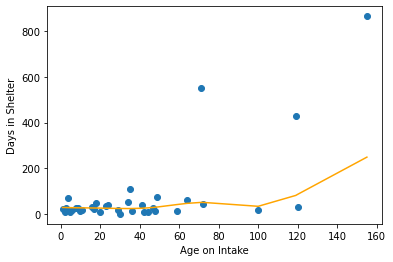

In [156]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

StdS_X = StandardScaler()
StdS_y = StandardScaler()
X_l = StdS_X.fit_transform(X.reshape(-1,1))
y_p = StdS_y.fit_transform(Y.reshape(-1,1))

regressor = SVR(kernel = 'rbf')
regressor.fit(X_l, y_p)

plt.scatter(StdS_X.inverse_transform(X_l), StdS_y.inverse_transform(y_p))
plt.plot(StdS_X.inverse_transform(X_l), StdS_y.inverse_transform(regressor.predict(X_l).reshape(-1,1)), color = 'orange')
plt.xlabel('Age on Intake')
plt.ylabel('Days in Shelter')
plt.show()

           3           2
0.0005906 x - 0.08278 x + 3.908 x - 5.757

Błąd średniokwadratowy wielomianu 3-tego stopnia: 1.06e+04



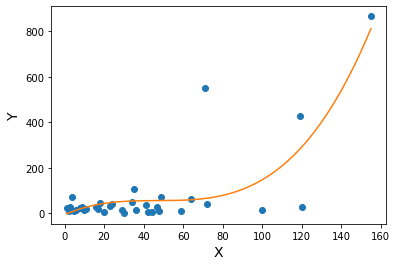

In [125]:
import numpy
p = numpy.poly1d(numpy.polyfit(X, Y, deg=3))
print(p)
Y_pred_values = p(X)
MSE_lin = mean_squared_error(Y, Y_pred_values)
print(f'\nBłąd średniokwadratowy wielomianu 3-tego stopnia: {MSE_lin:0.3}\n')
plt.scatter(X,Y)
plt.plot(os_x, p(os_x), color='tab:orange')
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.show()

           4           3          2
1.378e-05 x - 0.00353 x + 0.2962 x - 7.216 x + 58.02

Błąd średniokwadratowy wielomianu 4-tego stopnia: 9.28e+03



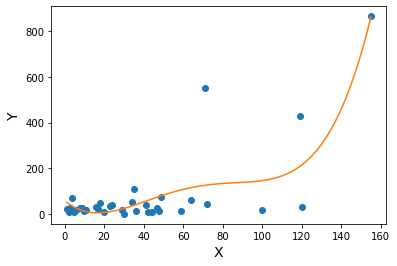

In [126]:
p = numpy.poly1d(numpy.polyfit(X, Y, deg=4))
print(p)
Y_pred_values = p(X)
MSE_lin = mean_squared_error(Y, Y_pred_values)
print(f'\nBłąd średniokwadratowy wielomianu 4-tego stopnia: {MSE_lin:0.3}\n')
plt.scatter(X,Y)
plt.plot(os_x, p(os_x), color='tab:orange')
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.show()

           5             4            3        2
2.004e-07 x - 5.906e-05 x + 0.005553 x - 0.16 x + 1.112 x + 25.48

Błąd średniokwadratowy wielomianu 5-tego stopnia: 9.04e+03



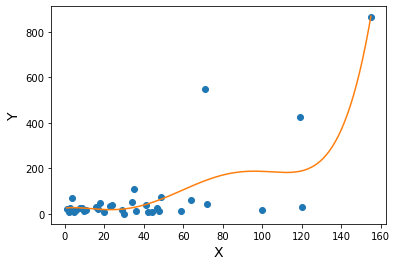

In [134]:
p = numpy.poly1d(numpy.polyfit(X, Y, deg=5))
print(p)
Y_pred_values = p(X)
MSE_lin = mean_squared_error(Y, Y_pred_values)
print(f'\nBłąd średniokwadratowy wielomianu 5-tego stopnia: {MSE_lin:0.3}\n')
plt.scatter(X,Y)
plt.plot(os_x, p(os_x), color='tab:orange')
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.show()

Parametry modelu liniowego: [2.97196], -44.77386
Błąd średniokwadratowy modelu liniowego: 1.9e+04

Parametry modelu GLM: [ 0.     -4.4725  0.0547], 82.82901
Błąd średniokwadratowy modelu GLM: 2.98e+04

Błąd średniokwadratowy modelu SVR: 3.03e+04


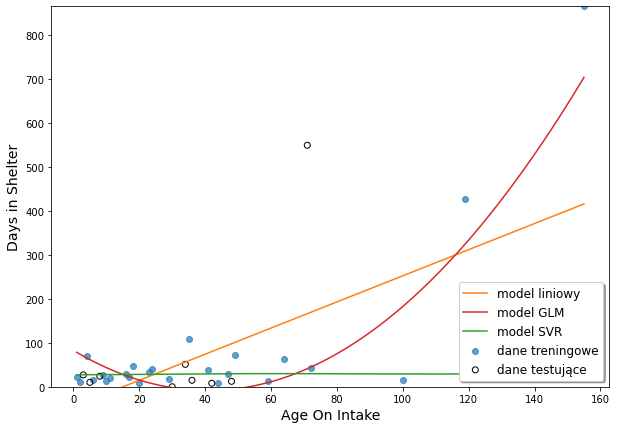

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)


# =========  Model liniowy =========
from sklearn.linear_model import LinearRegression
model_lin = LinearRegression()
model_lin.fit(X_train.reshape(-1,1), 
              Y_train)
print(f'Parametry modelu liniowego: {np.round(model_lin.coef_,5)}, {np.round(model_lin.intercept_,5)}')
MSE_lin = mean_squared_error(Y_test, model_lin.predict(X_test.reshape(-1,1)))
print(f'Błąd średniokwadratowy modelu liniowego: {MSE_lin:0.3}\n')

# ===== Uogólniony model liniowy (ang. Generalized Linear Model) =====
from sklearn.preprocessing import PolynomialFeatures
model_GLM = LinearRegression()
gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
model_GLM.fit(gen_features.fit_transform(X_train.reshape(-1,1)), 
              Y_train)
print(f'Parametry modelu GLM: {np.round(model_GLM.coef_,4)}, {np.round(model_GLM.intercept_,5)}')
MSE_GLM = mean_squared_error(Y_test, model_GLM.predict(gen_features.fit_transform(X_test.reshape(-1,1))))
print(f'Błąd średniokwadratowy modelu GLM: {MSE_GLM:0.3}\n')

#==== Maszyna wektorów wspierających (ang. Support Vector Machine) ====
# SVR dla regresji, SVC dla kalsyfikacji
from sklearn.svm import SVR
model_svr = SVR(kernel='rbf', gamma='scale', C=1)
model_svr.fit(X_train.reshape(-1,1), 
              Y_train)
MSE_SVR = mean_squared_error(Y_test, model_svr.predict(X_test.reshape(-1,1)))
print(f'Błąd średniokwadratowy modelu SVR: {MSE_SVR:0.3}')

# Predykcje wszystkich modeli dla całego zakreso osi X
os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
y_lin_pred = model_lin.predict(os_x.reshape(-1,1))
y_GLM_pred = model_GLM.predict(gen_features.fit_transform(os_x.reshape(-1,1)))
y_svr_pred = model_svr.predict(os_x.reshape(-1,1))

# Wizualizacja
plt.figure(figsize=(10,7))
plt.scatter(X_train, Y_train, label='dane treningowe', alpha=0.7)
plt.scatter(X_test, Y_test, edgecolor='black', facecolor='none', label='dane testujące')
plt.plot(os_x, y_lin_pred, label='model liniowy', color='tab:orange')
plt.plot(os_x, y_GLM_pred, label=f'model GLM', color='tab:red')
plt.plot(os_x, y_svr_pred, label='model SVR', color='tab:green')
plt.xlabel(dane.columns[0], fontsize=14)
plt.ylabel(dane.columns[1], fontsize=14)
plt.legend(fontsize=12, shadow=True, loc='lower right')
plt.ylim([Y.min()-0.1, Y.max()+0.5])
plt.show()